## Импорты

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression, Ridge, Lasso

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.inspection import DecisionBoundaryDisplay

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

## Загрузка датасета

In [2]:
path = '../arabica_data_cleaned.csv'
df = pd.read_csv(path, index_col='Unnamed: 0')

## Удаление "лишних" данных
В соответствии с результатами исследования данных на предыдущем этапе удаляем неполные строки, а также нерелевантные столбцы и данные с выбросами. 

In [3]:
df = df.drop(columns = ['Species', 'Farm.Name', 'Lot.Number',
       'Mill', 'ICO.Number', 'Expiration', 'Certification.Body',
       'Certification.Address', 'Certification.Contact', 
       'unit_of_measurement',  'Grading.Date','Variety', 'Processing.Method',
       'Altitude', 'Bag.Weight', 'Number.of.Bags',
       'altitude_low_meters', 'altitude_high_meters', 'Body', 'Balance', 'Uniformity',
       'Clean.Cup', 'Sweetness', 'Cupper.Points', 'Owner.1'])
df = df.dropna()
df.drop(df.loc[df['Total.Cup.Points'] == 0].index, inplace = True )
df.drop(df.loc[df['altitude_mean_meters'] > 10000].index, inplace = True )


## Категориальные столбцы
Есть 7 категориальных столбцов. Из них ординальный только один (Harvest.Year). Еще есть признак, у которого достаточно мало значений (Color), чтобы можно было использовать one-hot encoding. С остальными признаками так просто не получится работать, поэтому решено их отбросить.

In [4]:
df.select_dtypes(include='object').nunique()

Owner                 192
Country.of.Origin      31
Company               217
Region                239
Producer              458
In.Country.Partner     25
Harvest.Year           14
Color                   4
dtype: int64

In [5]:
df = df.drop(columns = ['Owner', 'Country.of.Origin', 'Company',
       'Region', 'Producer', 'In.Country.Partner'])

In [6]:
le = LabelEncoder()
df['Harvest.Year'] = le.fit_transform(df['Harvest.Year'])

In [7]:
ohe = OneHotEncoder()
res = ohe.fit_transform(df['Color'].to_numpy().reshape(-1, 1))
ohe_df = pd.DataFrame(res.toarray(), columns=ohe.get_feature_names_out())
ohe_df.head()

,x0_Blue-Green,x0_Bluish-Green,x0_Green,x0_None
0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0


Получившиеся признаки линейно-зависимы, так что можно один столбец отбросить.

In [8]:
df = df.drop(columns=['Color'])
df = df.join(ohe_df.drop(columns=['x0_None']))

In [9]:
df.head()

,Harvest.Year,Aroma,Flavor,Aftertaste,Acidity,Total.Cup.Points,Moisture,Category.One.Defects,Quakers,Category.Two.Defects,altitude_mean_meters,x0_Blue-Green,x0_Bluish-Green,x0_Green
1,5,8.67,8.83,8.67,8.75,90.58,0.12,0,0.0,0,2075.0,0.0,0.0,1.0
2,5,8.75,8.67,8.50,8.58,89.92,0.12,0,0.0,1,2075.0,0.0,0.0,1.0
4,5,8.17,8.58,8.42,8.42,89.00,0.11,0,0.0,2,2000.0,0.0,0.0,1.0
5,5,8.25,8.50,8.25,8.50,88.83,0.12,0,0.0,2,2075.0,0.0,0.0,1.0
10,5,8.08,8.58,8.50,8.50,88.25,0.10,0,0.0,4,1822.5,0.0,0.0,1.0


## Мультиколлинеарность
Решено отбросить признаки с коэффициентами больше 0.8

In [10]:
corrs = df.corr()
upper_tri = corrs.where(np.triu(np.ones(corrs.shape), k=1).astype(np.bool))
upper_tri

,Harvest.Year,Aroma,Flavor,Aftertaste,Acidity,Total.Cup.Points,Moisture,Category.One.Defects,Quakers,Category.Two.Defects,altitude_mean_meters,x0_Blue-Green,x0_Bluish-Green,x0_Green
Harvest.Year,NaN,0.005501,0.085442,0.073448,0.064124,0.110401,-0.193119,-0.074027,0.278723,-0.139578,-0.049665,-0.037274,-0.055615,0.098244
Aroma,NaN,NaN,0.760935,0.700759,0.646419,0.696964,-0.035403,-0.139363,0.004310,-0.218433,0.200598,0.058348,0.043505,-0.047671
Flavor,NaN,NaN,NaN,0.839464,0.766443,0.826538,-0.091608,-0.076324,0.019537,-0.234674,0.155486,0.059212,0.068041,-0.055918
Aftertaste,NaN,NaN,NaN,NaN,0.702052,0.830220,-0.148714,-0.113282,0.020347,-0.258652,0.135939,0.095026,0.049234,-0.075982
Acidity,NaN,NaN,NaN,NaN,NaN,0.720687,-0.084699,-0.081813,0.034899,-0.169379,0.242793,0.077716,0.041896,-0.060800
Total.Cup.Points,NaN,NaN,NaN,NaN,NaN,NaN,-0.115950,-0.156604,0.039539,-0.283077,0.160841,0.072002,0.067618,-0.058322
Moisture,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.057843,0.024094,0.115769,0.098569,-0.034131,0.014873,-0.005717
Category.One.Defects,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000800,0.384845,-0.064351,0.032137,-0.046874,0.023947
Quakers,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.019129,0.006748,-0.042487,-0.061531,0.045844
Category.Two.Defects,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.035721,-0.010706,0.054271,0.007068


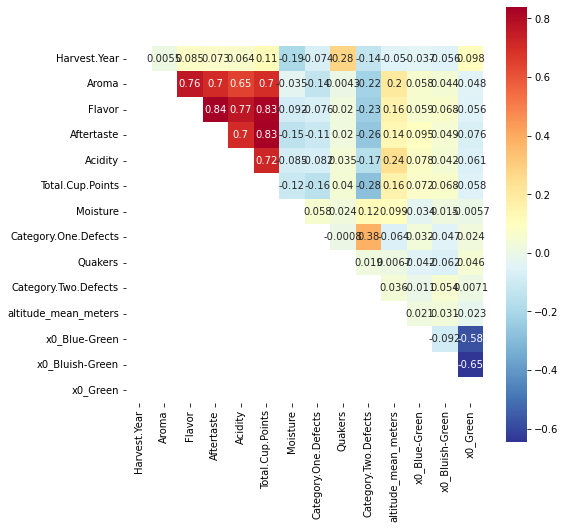

In [11]:
plt.figure(figsize=(8, 8))
sns.heatmap(upper_tri, cmap="RdYlBu_r", square=True, annot=True);

In [12]:
cols_to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.8)]
cols_to_drop

['Aftertaste', 'Total.Cup.Points']

In [13]:
cutted_data = df.drop(columns=cols_to_drop)
cutted_data.head()

,Harvest.Year,Aroma,Flavor,Acidity,Moisture,Category.One.Defects,Quakers,Category.Two.Defects,altitude_mean_meters,x0_Blue-Green,x0_Bluish-Green,x0_Green
1,5,8.67,8.83,8.75,0.12,0,0.0,0,2075.0,0.0,0.0,1.0
2,5,8.75,8.67,8.58,0.12,0,0.0,1,2075.0,0.0,0.0,1.0
4,5,8.17,8.58,8.42,0.11,0,0.0,2,2000.0,0.0,0.0,1.0
5,5,8.25,8.50,8.50,0.12,0,0.0,2,2075.0,0.0,0.0,1.0
10,5,8.08,8.58,8.50,0.10,0,0.0,4,1822.5,0.0,0.0,1.0


## Обучение модели
Подготовка данных

In [14]:
X, y = cutted_data.fillna(0), df['Total.Cup.Points']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25, stratify=round(y, -1))

Обычная линейная регрессия

In [15]:
lr = LinearRegression()
print('Cross validation for linear regression (MAE): ', - cross_val_score(lr, X_train, y_train, cv=4, scoring='neg_mean_absolute_error'))

Cross validation for linear regression (MAE):  [0.86552845 0.70601776 0.81971188 0.6954344 ]


Масштабирование:

In [16]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns
)

In [17]:
lr = LinearRegression()
print('Cross validation for linear regression after scaling (MAE): ', - cross_val_score(lr, X_train, y_train, cv=4, scoring='neg_mean_absolute_error'))

Cross validation for linear regression after scaling (MAE):  [0.86552845 0.70601776 0.81971188 0.6954344 ]


In [18]:
def plotCoefficients(model, columns):
    coefs = pd.DataFrame(model.coef_, columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)

    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed')

Работа с мультиколлинеарностью: видно уменьшение ошибки при использовании ridge

In [19]:
ridge = Ridge(alpha=1)
print('Ridge (MAE): ', - cross_val_score(ridge, X_train, y_train, cv=4, scoring='neg_mean_absolute_error'))

Ridge (MAE):  [0.85046429 0.69308178 0.82118685 0.6902    ]


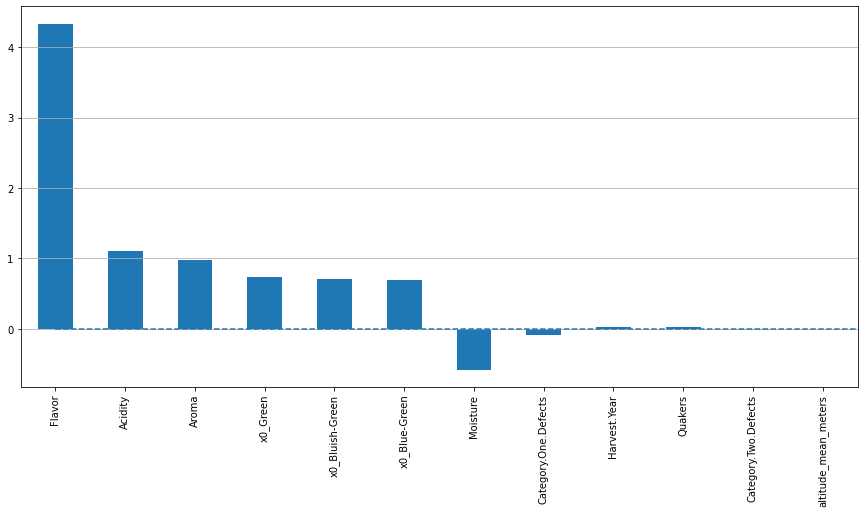

In [20]:
ridge.fit(X_train, y_train)
y_preds = ridge.predict(X_test)
plotCoefficients(ridge, X_train.columns)

In [21]:
lasso = Lasso(alpha=1)
print('Lasso (MAE): ', - cross_val_score(lasso, X_train, y_train, cv=4, scoring='neg_mean_absolute_error'))

Lasso (MAE):  [1.6517311  1.50777043 1.81184682 1.73628872]


## Подбор гиперпараметров

In [22]:
X, y = cutted_data.fillna(0), df['Total.Cup.Points']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25, stratify=round(y, -1))

In [23]:
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("clf", Ridge()),
    ]
)

In [30]:
parameters = {
    'scaler__with_mean': [True, False],
    'clf__alpha': np.linspace(90, 110, 100),
    'clf__random_state': [42]
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=parameters,
    n_jobs=2,
    verbose=1,
)

In [31]:
%%time

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
CPU times: user 415 ms, sys: 3.76 ms, total: 419 ms
Wall time: 2.82 s


GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf', Ridge())]),
             n_jobs=2,
             param_grid={'clf__alpha': array([ 90.        ,  90.2020202 ,  90.4040404 ,  90.60606061,
        90.80808081,  91.01010101,  91.21212121,  91.41414141,
        91.61616162,  91.81818182,  92.02020202,  92.22222222,
        92.42424242,  92.62626263,  92.82828283,  93.03030303,
        93.23232323,  93.43434343,  93.63636364,  93.838...
       105.35353535, 105.55555556, 105.75757576, 105.95959596,
       106.16161616, 106.36363636, 106.56565657, 106.76767677,
       106.96969697, 107.17171717, 107.37373737, 107.57575758,
       107.77777778, 107.97979798, 108.18181818, 108.38383838,
       108.58585859, 108.78787879, 108.98989899, 109.19191919,
       109.39393939, 109.5959596 , 109.7979798 , 110.        ]),
                         'clf__random_state': [42],
                         'scaler__with_mean': [True, False]},
             verbose=1)

In [32]:
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print(f"{param_name}: {best_parameters[param_name]}")

clf__alpha: 104.34343434343434
clf__random_state: 42
scaler__with_mean: False


In [33]:
y_pred_optimized = grid_search.best_estimator_.predict(X_test)

print('Ridge (MAE): ', mean_absolute_error(y_test, y_pred_optimized))

Ridge (MAE):  0.736380867773048


## Обучение модели с подобранными значениями гиперпараметров и измерение качества на выбранной метрике

In [35]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns
)
ridge = Ridge(alpha = 104.34, random_state=42)
ridge.fit(X_train_scaled, y_train)
y_pred = ridge.predict(X_test_scaled)

print('Ridge (MAE): ', mean_absolute_error(y_test, y_pred))

Ridge (MAE):  0.7363810908853466


## Визуализация и интерпретация
Коэффициенты для итоговой модели:

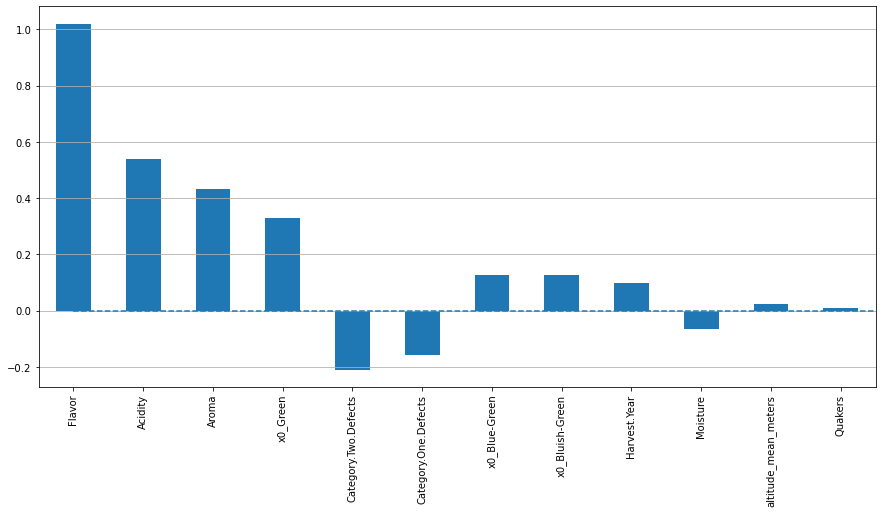

In [36]:
plotCoefficients(ridge, X_train.columns)

Визуализация результатов

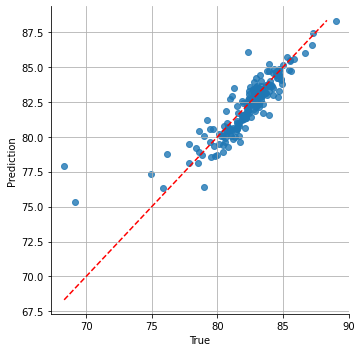

In [52]:
results = pd.DataFrame({'True': y_test, 'Prediction': y_pred})
sns.lmplot(x='True', y='Prediction', data=results, fit_reg=False)
d_line= np.arange(results.min().min(), results.max().max())
  
plt.plot(d_line, d_line, color='red', linestyle='--')
#plt.title = title
plt.grid()
plt.show()

**Выводы:**

1. Наибольшее влияние на оценку качества кофе, как и можно ожидать, оказывают признаки 'Flavor', 'Accidity' и 'Aroma'.
2. Признаки 'Category.one.defects', 'Category.two.defects' и 'Moisture' вышли со знаком минус, что тоже логично.
3. Было бы прикольно, если бы обнарудилось неожиданно сильное влияние какого-нибудь признака типа высоты сбора урожая, но нет так нет.
4. Данные довольно разбросанные, и, думаю, линейную модель было бы лучше не сделать.